In [7]:
%%time
%reset -f

import pandas as pd
from rdkit.Chem import AllChem, Draw, Descriptors   
from rdkit import Chem, DataStructs
from rdkit.Avalon.pyAvalonTools import GetAvalonFP
from rdkit.Chem import rdMolDescriptors
from rdkit.DataStructs import ExplicitBitVect

curcumin_variants = (
    "COc3cc(OC)c(C/C=C/C2=CC(/C=C/Cc1c(OC)cc(OC)cc1OC)=[O+][B-](F)(F)O2)c(OC)c3",
    "COc3ccc(C/C=C/C2=[O+][B-](F)(F)OC(/C=C/Cc1c(OC)cc(OC)cc1OC)=C2)cc3",
    "COc3ccc(C/C=C/C2=CC(/C=C/Cc1ccc(OC)cc1OC)=[O+][B-](F)(F)O2)c(OC)c3",
    "COc5ccc(C/C=C/C4=[O+][B-](F)(F)OC(/C=C/Cc2c1ccccc1cc3ccccc23)=C4)cc5",
    "COc3ccc(OC)c(C/C=C/C2=CC(/C=C/Cc1cc(OC)ccc1OC)=[O+][B-](F)(F)O2)c3",
    "COc3cc(C/C=C/C2=CC(/C=C/Cc1ccc(O)c(OC)c1)=[O+][B-](F)(F)O2)ccc3O",
    "CN(C)c3ccc(C/C=C/C2=CC(/C=C/Cc1ccc(N(C)C)cc1)=[O+][B-](F)(F)O2)cc3",
    "N#Cc3ccc(C/C=C/C2=[O+][B-](F)(F)OC(/C=C/Cc1ccccc1)=C2)cc3",
    "COc6ccc(C/C=C/C5=CC(/C=C/Cc1cc2ccc3cccc4ccc(c1)c2c34)=[O+][B-](F)(F)O5)cc6",
    "COc4ccc(C/C=C/C3=CC(/C=C/Cc1ccc(OC)c2ccccc12)=[O+][B-](F)(F)O3)c5ccccc45",
    "CN(C)c4ccc(C/C=C/C3=CC(/C=C/Cc1ccc(N(C)C)c2ccccc12)=[O+][B-](F)(F)O3)c5ccccc45",
    "CCCCN(CCCC)c3ccc(C/C=C/C2=CC(/C=C/Cc1ccc(N(CCCC)CCCC)cc1)=[O+][B-](F)(F)O2)cc3",
    "COc3ccc(C/C=C/C2=CC(/C=C/Cc1ccc(C#N)cc1)=[O+][B-](F)(F)O2)cc3",
    "CN5/C(=C\C\C=C\C3=CC(/C=C/C/C=C/2N(C)c1ccccc1C2(C)C)=[O+][B-](F)(F)O3)C(C)(C)c4ccccc45",
    "COc3ccc(C/C=C/C2=[O+][B-](F)(F)OC(/C=C/Cc1ccc(SC)cc1)=C2)cc3",
    "CSc3ccc(C/C=C/C2=CC(/C=C/Cc1ccc(SC)cc1)=[O+][B-](F)(F)O2)cc3",
    "COc3ccc(C/C=C/C2=CC(/C=C/Cc1ccc(N(C)C)cc1)=[O+][B-](F)(F)O2)cc3",
    "COc1ccccc1C/C=C/C3=CC(/C=C/Cc2ccccc2OC)=[O+][B-](F)(F)O3",
    "CCCCCC(CC)c5ccc(c4ccc(C/C=C/C3=CC(/C=C/Cc2ccc(c1ccc(C(CC)CCCCC)s1)s2)=[O+][B-](F)(F)O3)s4)s5"
)

molecule_names = ['2-ADMeO3', '3-MR83a', 'AD-10', 'AD-1013', 'AD-1022', 'AD-11', 'AD-14-Moore', 'AD-16-DMF', 'AD-18', 'AD-24', 'AD-25', 'AD-35', 'AD-4', 'AD-48', 'AD-5', 'AD-6', 'AD-7', 'AD-9', 'YD-30']
homo_lumo_gap = [3.077, 3.072, 3.259, 2.625, 2.938, 2.946, 2.811, 3.231, 2.735, 2.878, 2.686, 2.77, 3.001, 2.702, 2.97, 2.89, 2.859, 3.137, 2.525]

molecules = [Chem.MolFromSmiles(smiles) for smiles in curcumin_variants]
mws = [round(Descriptors.MolWt(mol),3) for mol in molecules]
logp = [Descriptors.MolLogP(mol) for mol in molecules]

# Create the initial DataFrame of Curcumin
data = {
    'Molecule': molecule_names,
    'Molecular Weight': mws,
    'LogP': logp,
    'Homo-Lumo Gap (eV)': homo_lumo_gap,
    'Smiles': curcumin_variants
}
curcumin_df = pd.DataFrame(data)

def generate_morgan_fingerprint_safe(smiles):
    """Generate Morgan fingerprint and handle errors gracefully."""
    try:
        mol = Chem.MolFromSmiles(smiles)
        if mol:
            return list(AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=2048))
    except Exception:
        return None
    return None

# apply morgan fingerprint to the curcumin_df dataframe
curcumin_df['Morgan_Fingerprints'] = curcumin_df['Smiles'].apply(generate_morgan_fingerprint_safe)
curcumin_df = curcumin_df[curcumin_df['Morgan_Fingerprints'].notnull()].reset_index(drop=True)
morgan_df = pd.DataFrame(curcumin_df['Morgan_Fingerprints'].tolist(), columns=[f'morgan_{i}' for i in range(2048)])

curcumin_df_mf = pd.concat([curcumin_df.drop(columns=['Morgan_Fingerprints']), morgan_df], axis=1)

# Convert any fingerprint to a bit vector
def convert_to_bit_vector(fp, nBits=2048):
    bit_vector = ExplicitBitVect(nBits)
    for bit in fp.GetNonzeroElements().keys():
        bit_vector.SetBit(bit % nBits)
    return bit_vector

# Atom pair Fingerprint bit vector conversion
def generate_atom_pair_fingerprint(mol, nBits=2048):
    fp = rdMolDescriptors.GetAtomPairFingerprint(mol)
    return convert_to_bit_vector(fp, nBits)

# Function to generate fingerprints
def generate_fingerprint(mol, fp_type, radius=2, n_bits=2048):
    if fp_type == 'morgan':
        return AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits=n_bits, useChirality=True)
    elif fp_type == 'fcfp':
        return AllChem.GetMorganFingerprintAsBitVect(mol, radius=3, nBits=n_bits, useChirality=True)
    elif fp_type == 'atom_pair':
        return generate_atom_pair_fingerprint(mol, nBits=n_bits)

# Similarity functions
def calculate_similarity(fp1, fp2, metric):
    if metric == 'tanimoto':
        return DataStructs.TanimotoSimilarity(fp1, fp2)
    elif metric == 'dice':
        return DataStructs.DiceSimilarity(fp1, fp2)
    elif metric == 'cosine':
        return DataStructs.CosineSimilarity(fp1, fp2)
    elif metric == 'kulczynski':
        return DataStructs.KulczynskiSimilarity(fp1, fp2)

curcumin_similarity_variants = {
    "seg01" : "Cc2ccc(/C=C/C(=O)CC(=O)/C=C/c1ccc(C)cc1)cc2",
    "seg02" : "C/C=C/C(=O)CC(=O)/C=C/c1ccc(C)cc1",
    "seg03" : "C/C=C/C(=O)CC(=O)/C=C/C",
    "seg04" : "Cc1ccc(/C=C/C=O)cc1",
    "seg05" : "C/C=C/C=O",
    "seg06" : "C/C=C/C1=CC(/C=C/C)=[O+][B-](F)(F)O1",
}

# Harvard OPV dataset import
data = pd.read_csv('https://raw.githubusercontent.com/AjStephan/havard-smile-opv/main/Non-fullerene%20small-molecules%20acceptors.csv')
opv_df = data.drop(columns=[
    'index', 'inchikey', 'LUMO_calib_stds', 'HOMO_calib_stds',
    'molW', 'PCE_calc', 'Voc_calc', 'Jsc_calc',
    'FF_calc', 'EQE_calc', 'PCE_calib', 'Voc_calib', 'Jsc_calib', 'FF_calib',
    'EQE_calib', 'PCE_cdiff', 'PCE_calib_plus'], axis=1)

opv_df['mol'] = opv_df['smiles'].apply(Chem.MolFromSmiles)

opv_df_sorted = opv_df.sort_values(by='LUMO_calc')
opv_df_filtered = opv_df_sorted[opv_df_sorted['LUMO_calc'] <= -3.5]
opv_df_filtered.reset_index(drop=True, inplace=True)

# Dictionary to hold the dataframes
similarity_dfs = {}

# Fingerprints and similarity methods
fingerprints = ['morgan', 'atom_pair']
similarities = ['tanimoto', 'cosine', 'kulczynski', 'dice']

# Loop over curcumin segments, fingerprints, and similarities
for key, smiles in curcumin_similarity_variants.items():
    specific_mol = Chem.MolFromSmiles(smiles)
    
    for fp_type in fingerprints:
        specific_fp = generate_fingerprint(specific_mol, fp_type)
        
        for sim_metric in similarities:
            opv_df_sim_segment = opv_df_filtered.copy()
            opv_df_sim_segment[f'similarity_{key}_{fp_type}_{sim_metric}'] = opv_df_sim_segment['mol'].apply(lambda x: calculate_similarity(generate_fingerprint(x, fp_type), specific_fp, sim_metric))
            
            # Filter top 48% similar molecules
            quantile_value = opv_df_sim_segment[f'similarity_{key}_{fp_type}_{sim_metric}'].quantile(0.52)
            opv_df_sim_segment = opv_df_sim_segment[opv_df_sim_segment[f'similarity_{key}_{fp_type}_{sim_metric}'] >= quantile_value]
            
            # Keep only the relevant columns (initial columns + similarity)
            opv_df_sim_segment = opv_df_sim_segment[['smiles', 'mol', 'GAP_calc', f'similarity_{key}_{fp_type}_{sim_metric}']]
            
            # Store the filtered dataframe in the dictionary
            similarity_dfs[f'{key}_{fp_type}_{sim_metric}'] = opv_df_sim_segment

            print(f"Generated dataframe for segment {key}, fingerprint {fp_type}, similarity {sim_metric}: shape {opv_df_sim_segment.shape}")

Generated dataframe for segment seg01, fingerprint morgan, similarity tanimoto: shape (6179, 4)
Generated dataframe for segment seg01, fingerprint morgan, similarity cosine: shape (6239, 4)
Generated dataframe for segment seg01, fingerprint morgan, similarity kulczynski: shape (6191, 4)
Generated dataframe for segment seg01, fingerprint morgan, similarity dice: shape (6179, 4)
Generated dataframe for segment seg01, fingerprint atom_pair, similarity tanimoto: shape (6115, 4)
Generated dataframe for segment seg01, fingerprint atom_pair, similarity cosine: shape (6112, 4)
Generated dataframe for segment seg01, fingerprint atom_pair, similarity kulczynski: shape (6113, 4)
Generated dataframe for segment seg01, fingerprint atom_pair, similarity dice: shape (6115, 4)
Generated dataframe for segment seg02, fingerprint morgan, similarity tanimoto: shape (6126, 4)
Generated dataframe for segment seg02, fingerprint morgan, similarity cosine: shape (6132, 4)
Generated dataframe for segment seg02,

In [8]:
opv_df_filtered.columns

Index(['smiles', 'HOMO_calc', 'LUMO_calc', 'LUMO_calib', 'HOMO_calib',
       'GAP_calib', 'GAP_calc', 'mol'],
      dtype='object')

In [9]:
similarity_dfs["seg01_atom_pair_cosine"].columns

Index(['smiles', 'mol', 'GAP_calc', 'similarity_seg01_atom_pair_cosine'], dtype='object')

In [10]:
%%time
import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem, rdMolDescriptors

# Function to generate Morgan fingerprints safely
def generate_morgan_fingerprint_safe(smiles):
    """Generate Morgan fingerprint and handle errors gracefully."""
    try:
        mol = Chem.MolFromSmiles(smiles)
        if mol:
            return list(AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=2048))
    except Exception as e:
        print(f"Error generating Morgan fingerprint for SMILES {smiles}: {e}")
        return None
    return None

# Dictionary to store processed dataframes
processed_similarity_dfs = {}

# Process each dataframe
for combination, df in similarity_dfs.items():
    print(f"Processing {combination}...")
    df = df.copy()
    
    # Generate Morgan fingerprints
    df['Morgan_Fingerprints'] = df['smiles'].apply(generate_morgan_fingerprint_safe)
    df = df[df['Morgan_Fingerprints'].notnull()].reset_index(drop=True)
    
    # Convert Morgan fingerprints to a DataFrame and concatenate with the original
    morgan_df = pd.DataFrame(df['Morgan_Fingerprints'].tolist(), columns=[f'morgan_{i}' for i in range(2048)])

    df_combined = pd.concat([df.drop(columns=['Morgan_Fingerprints']), morgan_df], axis=1)
    
    # Store the combined DataFrame
    processed_similarity_dfs[combination] = df_combined
    print(f"Finished processing {combination} - shape {df_combined.shape}")

# Unpacking the dictionary to individual DataFrames
for combination, df in processed_similarity_dfs.items():
    globals()[f'similarity_dfs_{combination}'] = df

Processing seg01_morgan_tanimoto...
Finished processing seg01_morgan_tanimoto - shape (6179, 2052)
Processing seg01_morgan_cosine...
Finished processing seg01_morgan_cosine - shape (6239, 2052)
Processing seg01_morgan_kulczynski...
Finished processing seg01_morgan_kulczynski - shape (6191, 2052)
Processing seg01_morgan_dice...
Finished processing seg01_morgan_dice - shape (6179, 2052)
Processing seg01_atom_pair_tanimoto...
Finished processing seg01_atom_pair_tanimoto - shape (6115, 2052)
Processing seg01_atom_pair_cosine...
Finished processing seg01_atom_pair_cosine - shape (6112, 2052)
Processing seg01_atom_pair_kulczynski...
Finished processing seg01_atom_pair_kulczynski - shape (6113, 2052)
Processing seg01_atom_pair_dice...
Finished processing seg01_atom_pair_dice - shape (6115, 2052)
Processing seg02_morgan_tanimoto...
Finished processing seg02_morgan_tanimoto - shape (6126, 2052)
Processing seg02_morgan_cosine...
Finished processing seg02_morgan_cosine - shape (6132, 2052)
Proces

In [11]:
processed_similarity_dfs["seg01_atom_pair_cosine"].columns

Index(['smiles', 'mol', 'GAP_calc', 'similarity_seg01_atom_pair_cosine',
       'morgan_0', 'morgan_1', 'morgan_2', 'morgan_3', 'morgan_4', 'morgan_5',
       ...
       'morgan_2038', 'morgan_2039', 'morgan_2040', 'morgan_2041',
       'morgan_2042', 'morgan_2043', 'morgan_2044', 'morgan_2045',
       'morgan_2046', 'morgan_2047'],
      dtype='object', length=2052)

In [12]:
%%time
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import lightgbm as lgb
import math

# Mappings for segments, fingerprint types, and similarity methods
segment_map = {
    'seg01': 'Segment 01',
    'seg02': 'Segment 02',
    'seg03': 'Segment 03',
    'seg04': 'Segment 04',
    'seg05': 'Segment 05',
    "seg06" : "Segment 06",
}

fingerprint_map = {
    'morgan': 'Morgan Fingerprint',
    'atom_pair': 'Atom Pair Fingerprint'
}

similarity_map = {
    'tanimoto': 'Tanimoto Similarity',
    'cosine': 'Cosine Similarity',
    'kulczynski': 'Kulczynski Similarity',
    'dice': 'Dice Similarity'
}

# Initialize a list to store results
results = []

# Process each dataframe from the global namespace
for combination, df in processed_similarity_dfs.items():
    print(f"Processing {combination}...")
    
    # Extract features (X) and target (y)
    X = df.iloc[:, 4:]  # Assuming the first 4 columns are non-feature columns
    y = df['GAP_calc']  # Target variable
    
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=123)
    
    # Initialize and train the LightGBM model
    tuned_params = {'n_estimators': 1000, 'learning_rate': 0.23685145356420312, 'num_leaves': 51}
    model = lgb.LGBMRegressor(**tuned_params)
    model.fit(X_train, y_train)
    
    # Make predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Calculate R^2 scores and RMSE
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    train_rmse = math.sqrt(mean_squared_error(y_train, y_train_pred))
    test_rmse = math.sqrt(mean_squared_error(y_test, y_test_pred))
    
    # Extracting segment, fingerprint type, and similarity method from the combination name
    parts = combination.split('_')  # Split the combination string into parts
    
    # Handle the case where the fingerprint type is 'atom_pair'
    if '_'.join(parts[1:3]) == 'atom_pair':
        segment_key = parts[0]  # Assuming the segment is the first part
        fingerprint_type_key = '_'.join(parts[1:3])  # Join parts to get 'atom_pair'
        similarity_method_key = parts[3]  # Similarity method is the fourth part
    else:
        segment_key = parts[0]  # Assuming the segment is the first part
        fingerprint_type_key = parts[1]  # Fingerprint type is the second part
        similarity_method_key = parts[2]  # Similarity method is the third part
    
    # Map the keys to human-readable names using the mappings
    segment_name = segment_map.get(segment_key, segment_key)
    fingerprint_name = fingerprint_map.get(fingerprint_type_key, fingerprint_type_key)
    similarity_name = similarity_map.get(similarity_method_key, similarity_method_key)
    
    # Store results in the list
    results.append({
        'Segment': segment_name,
        'Fingerprint Type': fingerprint_name,
        'Similarity Method': similarity_name,
        'Train R2 Score': train_r2,
        'Test R2 Score': test_r2,
        'Train RMSE': train_rmse,
        'Test RMSE': test_rmse
    })
    
    print(f"Done processing {combination} with Test R^2 score: {test_r2} and Test RMSE: {test_rmse}")

# Convert results to a DataFrame for further analysis
final_results = pd.DataFrame(results)

# Save the results to a CSV file for further use
final_results.to_csv(path_or_buf=r"C:\Users\Chamod Peiris\Documents\Curcumin_Scripts\LUMO_Filtered_Segmented_Analysis.csv")

# Display the first few rows of the results
final_results.head()

Processing seg01_morgan_tanimoto...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006359 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1726
[LightGBM] [Info] Number of data points in the train set: 4634, number of used features: 863
[LightGBM] [Info] Start training from score 2.763140
Done processing seg01_morgan_tanimoto with Test R^2 score: 0.9366143657103961 and Test RMSE: 0.13821138642188033
Processing seg01_morgan_cosine...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005128 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1730
[LightGBM] [Info] Number of data points in the train set: 4679, number of used features: 865
[LightGBM] [Info] Start training from score 2.757577
Done 

,Segment,Fingerprint Type,Similarity Method,Train R2 Score,Test R2 Score,Train RMSE,Test RMSE
0,Segment 01,Morgan Fingerprint,Tanimoto Similarity,0.999262,0.936614,0.015085,0.138211
1,Segment 01,Morgan Fingerprint,Cosine Similarity,0.999251,0.935437,0.015001,0.136450
2,Segment 01,Morgan Fingerprint,Kulczynski Similarity,0.999340,0.943760,0.013657,0.131820
3,Segment 01,Morgan Fingerprint,Dice Similarity,0.999262,0.936614,0.015085,0.138211
4,Segment 01,Atom Pair Fingerprint,Tanimoto Similarity,0.999537,0.954020,0.011526,0.114942


In [17]:
import pandas as pd
import plotly.graph_objects as go
import plotly.express as px

# Load the results from the CSV file
final_results = pd.read_csv(r"C:\Users\Chamod Peiris\Documents\Curcumin_Scripts\LUMO_Filtered_Segmented_Analysis.csv")

# Calculate the absolute variance between Train and Test R² scores
final_results['Variance'] = abs(final_results['Train R2 Score'] - final_results['Test R2 Score'])

# Create six plots, one for each segment
for segment in final_results['Segment'].unique():
    # Filter data for the current segment
    segment_data = final_results[final_results['Segment'] == segment]
    
    # Identify the best model (highest Test R² score)
    best_model = segment_data.loc[segment_data['Test R2 Score'].idxmax()]
    
    # Create a grouped bar plot for Train and Test R² scores
    fig = go.Figure()
    
    # Add bars for Train R² scores
    fig.add_trace(go.Bar(
        x=segment_data['Fingerprint Type'] + ' - ' + segment_data['Similarity Method'],
        y=segment_data['Train R2 Score'],
        name='Train R² Score',
        marker_color='blue',
        text=segment_data['Train R2 Score'].round(4),
        textposition='auto'
    ))
    
    # Add bars for Test R² scores
    fig.add_trace(go.Bar(
        x=segment_data['Fingerprint Type'] + ' - ' + segment_data['Similarity Method'],
        y=segment_data['Test R2 Score'],
        name='Test R² Score',
        marker_color='orange',
        text=segment_data['Test R2 Score'].round(4),
        textposition='auto'
    ))
    
    # Add a line for the absolute variance (secondary y-axis)
    fig.add_trace(go.Scatter(
        x=segment_data['Fingerprint Type'] + ' - ' + segment_data['Similarity Method'],
        y=segment_data['Variance'],
        mode='lines+markers',
        name='Absolute Variance',
        yaxis='y2',
        line=dict(color='red', dash='dash')
    ))
    
    # Update layout to include secondary y-axis
    fig.update_layout(
        title=f'R² Scores and Variance for {segment}',
        xaxis_title='Fingerprint Type - Similarity Method',
        yaxis_title='R² Score',
        yaxis2=dict(
            title='Absolute Variance',
            overlaying='y',
            side='right',
            showgrid=False,
            zeroline=False
        ),
        barmode='group',
        legend=dict(x=0.85, y=1.0),
        width=1000,
        height=600
    )
    
    # Add annotation for the best model
    fig.add_annotation(
        x=best_model['Fingerprint Type'] + ' - ' + best_model['Similarity Method'],
        y=best_model['Test R2 Score'],
        text=f"Best Model:<br>Test R²={best_model['Test R2 Score']:.4f}<br>{best_model['Fingerprint Type']} - {best_model['Similarity Method']}",
        showarrow=True,
        arrowhead=3,
        ax=0,
        ay=-50,
        font=dict(color="black", size=12),
        bgcolor="silver"
    )

    # legend orientation
    fig.update_layout(
    legend=dict(
        orientation='h',  # Horizontal orientation
        yanchor='bottom',
        y=1.01,  # Position above the plot
        xanchor='center',
        x=0.5  # Center horizontally
    )
)
    
    # Show the plot
    fig.show()

In [21]:
import pandas as pd
import plotly.graph_objects as go

# Load the results from the CSV file
final_results = pd.read_csv(r"C:\Users\Chamod Peiris\Documents\Curcumin_Scripts\LUMO_Filtered_Segmented_Analysis.csv")

# Calculate the absolute variance between Train and Test R² scores
final_results['Variance'] = abs(final_results['Train R2 Score'] - final_results['Test R2 Score'])

# Initialize an empty list to store the best models from all segments
best_models_list = []

# Process each segment to find the best model
for segment in final_results['Segment'].unique():
    # Filter data for the current segment
    segment_data = final_results[final_results['Segment'] == segment]
    
    # Identify the best model (highest Test R² score)
    best_model = segment_data.loc[segment_data['Test R2 Score'].idxmax()]
    
    # Convert the Series to a DataFrame and append it to the list
    best_models_list.append(pd.DataFrame([best_model]))

# Concatenate the list of best models into a DataFrame
best_models_all_segments = pd.concat(best_models_list, ignore_index=True)

# Create a grouped bar plot for Train and Test R² scores of the best models
fig = go.Figure()

# Add bars for Train R² scores
fig.add_trace(go.Bar(
    x=best_models_all_segments['Segment'] + ' - ' + best_models_all_segments['Fingerprint Type'] + ' - ' + best_models_all_segments['Similarity Method'],
    y=best_models_all_segments['Train R2 Score'],
    name='Train R² Score',
    marker_color='blue',
    text=best_models_all_segments['Train R2 Score'].round(4),
    textposition='auto'
))

# Add bars for Test R² scores
fig.add_trace(go.Bar(
    x=best_models_all_segments['Segment'] + ' - ' + best_models_all_segments['Fingerprint Type'] + ' - ' + best_models_all_segments['Similarity Method'],
    y=best_models_all_segments['Test R2 Score'],
    name='Test R² Score',
    marker_color='orange',
    text=best_models_all_segments['Test R2 Score'].round(4),
    textposition='auto'
))

# Add a line for the absolute variance (secondary y-axis)
fig.add_trace(go.Scatter(
    x=best_models_all_segments['Segment'] + ' - ' + best_models_all_segments['Fingerprint Type'] + ' - ' + best_models_all_segments['Similarity Method'],
    y=best_models_all_segments['Variance'],
    mode='lines+markers',
    name='Absolute Variance',
    yaxis='y2',
    line=dict(color='red', dash='dash')
))

# Update layout to include secondary y-axis
fig.update_layout(
    title='Best Models Across All Segments',
    xaxis_title='Model',
    yaxis_title='R² Score',
    yaxis2=dict(
        title='Absolute Variance',
        overlaying='y',
        side='right',
        showgrid=False,
        zeroline=False
    ),
    barmode='group',
    legend=dict(x=0.85, y=1.0),
    width=1000,
    height=600
)

# legend orientation
fig.update_layout(
    legend=dict(
        orientation='h',  # Horizontal orientation
        yanchor='bottom',
        y=1.01,  # Position above the plot
        xanchor='center',
        x=0.5  # Center horizontally
    )
)

# Show the plot
fig.show()

In [22]:
    import pandas as pd
    import matplotlib.pyplot as plt
    import numpy as np
    from sklearn.metrics import mean_absolute_error, mean_squared_error
    from sklearn.model_selection import train_test_split
    import lightgbm as lgb

    # List of the best model dataframes
    best_models_all_segments = ["similarity_dfs_seg01_atom_pair_cosine",
                                "similarity_dfs_seg02_atom_pair_cosine", 
                                "similarity_dfs_seg03_atom_pair_kulczynski", 
                                "similarity_dfs_seg04_atom_pair_kulczynski", 
                                "similarity_dfs_seg05_atom_pair_kulczynski",
                                "similarity_dfs_seg06_atom_pair_cosine"]

    # Iterate through the list of best models
    for model_name in best_models_all_segments:
        # Dynamically reference the corresponding dataframe
        model_df = globals()[model_name]
        
        x = model_df.iloc[:, 4:]
        y = model_df['GAP_calc']
        
        # Split the data into training and testing sets
        x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=123)
        
        # Initialize and train the LightGBM model
        tuned_params = {'n_estimators': 1000, 'learning_rate': 0.23685145356420312, 'num_leaves': 51}
        model = lgb.LGBMRegressor(**tuned_params)
        model.fit(x_train, y_train)
        
        # Make predictions and calculate R^2 score
        y_pred = model.predict(x_test)
        
        # Calculate MAE Value and RMSE for the model
        mae_model = mean_absolute_error(y_test, y_pred)
        rmse_model = mean_squared_error(y_test, y_pred, squared=False)
        
        # Calculate R2 score for the model
        r2_model = model.score(x_test, y_test)

        curcumin_df_mf_pred = curcumin_df_mf.copy()
        curcumin_df_mf_pred['Homo-Lumo Gap (eV) Pred'] = model.predict(curcumin_df_mf.iloc[:, 5:])
        
        mae_predict = mean_absolute_error(curcumin_df_mf_pred['Homo-Lumo Gap (eV)'], curcumin_df_mf_pred['Homo-Lumo Gap (eV) Pred'])
        rmse_predict = mean_squared_error(curcumin_df_mf_pred['Homo-Lumo Gap (eV)'], curcumin_df_mf_pred['Homo-Lumo Gap (eV) Pred'])
        r2_predict = model.score(curcumin_df_mf_pred['Homo-Lumo Gap (eV)'], curcumin_df_mf_pred['Homo-Lumo Gap (eV) Pred'])
        
        print("___________________________________________________________________")
        print(f"Model {model_name}")
        print(f"MAE Value: {mae_model:.5f} & RMSE Value: {rmse_model:.5f}")
        print(f"Prediction --> model MAE: {mae_predict:.5f} & RMSE: {rmse_predict:.5f}")
        print(f"Prediction --> model R2 Score: {r2_predict:.4f}")   
        print("___________________________________________________________________")
        
        # Sort curcumin_df_mf_pred by 'Homo-Lumo Gap (eV)' in descending order and reset the index
        curcumin_df_mf_pred = curcumin_df_mf_pred.sort_values(by='Homo-Lumo Gap (eV)', ascending=False).reset_index(drop=True)
        
        # Calculate the absolute variance between 'Homo-Lumo Gap (eV)' and 'Homo-Lumo Gap (eV) Pred'
        curcumin_df_mf_pred['absolute_variance'] = (curcumin_df_mf_pred['Homo-Lumo Gap (eV)'] - curcumin_df_mf_pred['Homo-Lumo Gap (eV) Pred']).abs()
        
        # Save DF
        curcumin_df_mf_pred.to_csv(path_or_buf=(f"C:/Users/Chamod Peiris/Documents/Curcumin_Scripts/curcumin_pred_48_{model_name}.csv"))

        # Calculate linear trendline for absolute variance
        x_vals = curcumin_df_mf_pred.index
        y_vals = curcumin_df_mf_pred['absolute_variance']
        coefficients = np.polyfit(x_vals, y_vals, 1)  # Fit a linear polynomial
        trendline = np.polyval(coefficients, x_vals)
        
        # Calculate the average absolute variance
        average_variance = y_vals.mean()
        
        # Plotting the actual vs predicted energy gaps
        fig, ax1 = plt.subplots(figsize=(12, 6))
        
        # Plot the actual values
        ax1.plot(curcumin_df_mf_pred['Molecule'], curcumin_df_mf_pred['Homo-Lumo Gap (eV)'], marker='s', label='Actual HOMO-LUMO Gap (eV)', color='orange')
        
        # Plot the predicted values
        ax1.plot(curcumin_df_mf_pred['Molecule'], curcumin_df_mf_pred['Homo-Lumo Gap (eV) Pred'], marker='x', linestyle='--', label='Predicted HOMO-LUMO Gap (eV)', color='blue')
        
        # Plot the absolute variance as a dotted line
        ax1.plot(curcumin_df_mf_pred['Molecule'], curcumin_df_mf_pred['absolute_variance'], marker='v', linestyle=':', label='Absolute Variance', color='crimson')
        
        # Plot the trendline for absolute variance
        ax1.plot(curcumin_df_mf_pred['Molecule'], trendline, linestyle='-', color='grey', label=f'Trendline (Avg. Abs. Variance: {average_variance:.2f} eV)')
        
        # Set labels for the axes and the range
        ax1.set_xlabel('Curcumin Derivative Molecule Name')
        ax1.set_ylabel('Energy Gap (eV)')
        ax1.set_ylim([0, 4.2])  # Adjust the y-axis range as needed
        ax1.tick_params(axis='y')
        ax1.legend(loc='upper right')
        
        # Customize the plot
        plt.title(f'Comparison of Actual vs Predicted HOMO-LUMO Gap (eV) and Absolute Variance\nModel: {model_name}')
        plt.grid(True)
        plt.tight_layout()
        plt.xticks(rotation=90)
        
        # Show the plot
        plt.show()

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005712 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1632
[LightGBM] [Info] Number of data points in the train set: 4584, number of used features: 816
[LightGBM] [Info] Start training from score 2.668804


c:\Users\Chamod Peiris\Documents\GitHub\Curcumin_BendGap_Cheminfo\.venv\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning:

'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.



ValueError: Expected a 2-dimensional container but got <class 'pandas.core.series.Series'> instead. Pass a DataFrame containing a single row (i.e. single sample) or a single column (i.e. single feature) instead.

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005352 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1632
[LightGBM] [Info] Number of data points in the train set: 4584, number of used features: 816
[LightGBM] [Info] Start training from score 2.668804


c:\Users\Chamod Peiris\Documents\GitHub\Curcumin_BendGap_Cheminfo\.venv\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning:

'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.



___________________________________________________________________
Model similarity_dfs_seg01_atom_pair_cosine
MAE Value: 0.07571 & RMSE Value: 0.10773
Prediction --> model MAE: 0.29041 & RMSE: 0.12289
Prediction --> model R2 Score: -2.1997
___________________________________________________________________


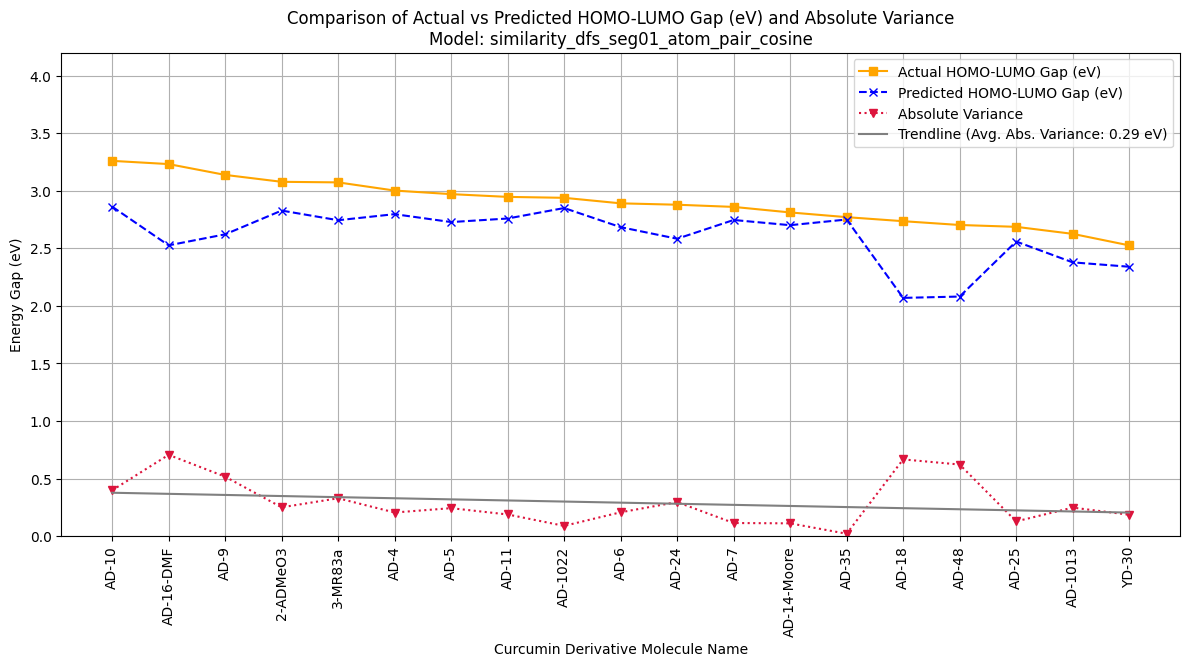

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006255 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1698
[LightGBM] [Info] Number of data points in the train set: 4581, number of used features: 849
[LightGBM] [Info] Start training from score 2.668061


c:\Users\Chamod Peiris\Documents\GitHub\Curcumin_BendGap_Cheminfo\.venv\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning:

'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.



___________________________________________________________________
Model similarity_dfs_seg02_atom_pair_cosine
MAE Value: 0.07721 & RMSE Value: 0.11105
Prediction --> model MAE: 0.12890 & RMSE: 0.02748
Prediction --> model R2 Score: 0.2846
___________________________________________________________________


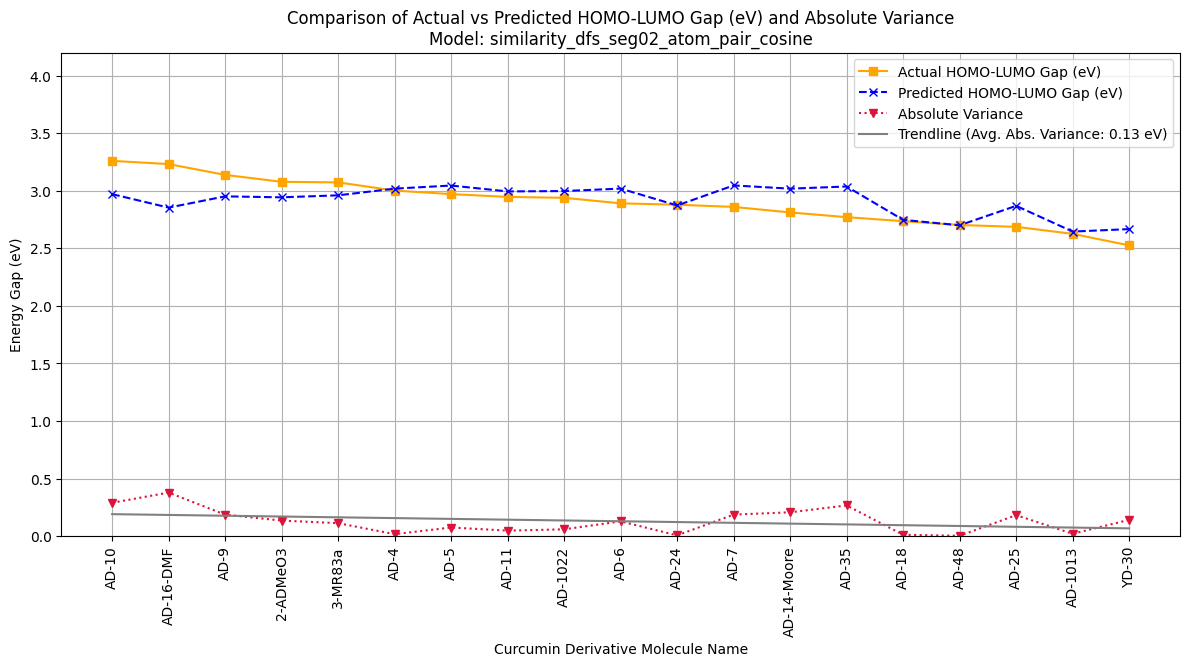

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006092 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1654
[LightGBM] [Info] Number of data points in the train set: 4581, number of used features: 827
[LightGBM] [Info] Start training from score 2.679562


c:\Users\Chamod Peiris\Documents\GitHub\Curcumin_BendGap_Cheminfo\.venv\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning:

'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.



___________________________________________________________________
Model similarity_dfs_seg03_atom_pair_kulczynski
MAE Value: 0.07073 & RMSE Value: 0.10255
Prediction --> model MAE: 0.17386 & RMSE: 0.04566
Prediction --> model R2 Score: -0.1889
___________________________________________________________________


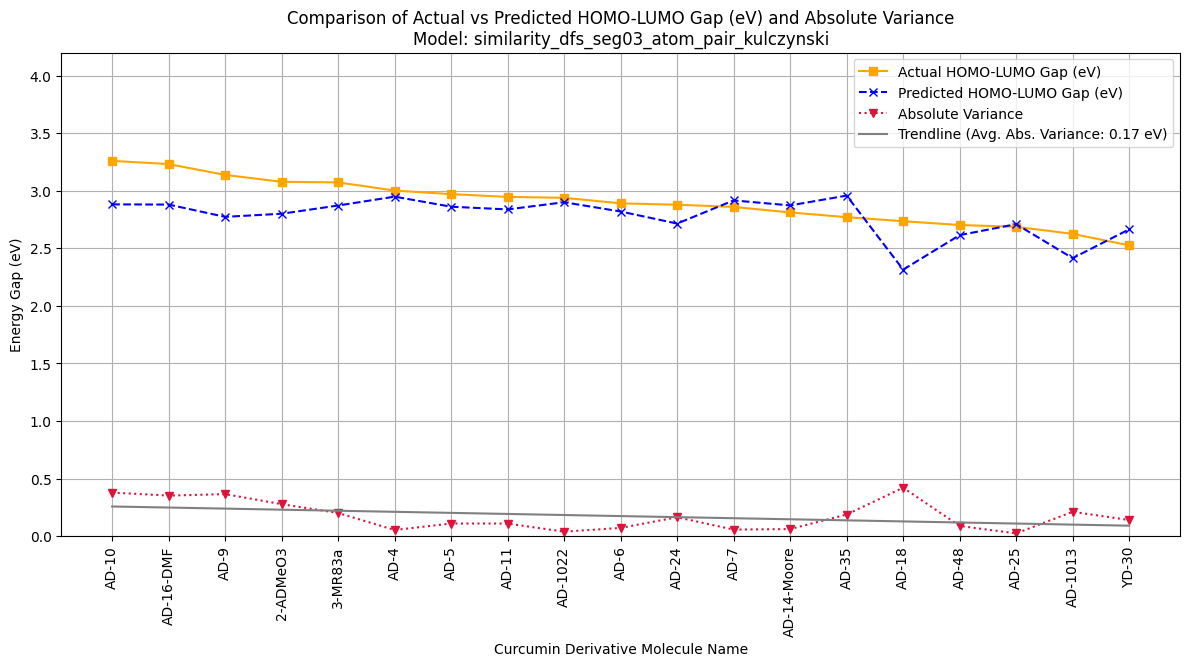

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004910 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1658
[LightGBM] [Info] Number of data points in the train set: 4673, number of used features: 829
[LightGBM] [Info] Start training from score 2.693885


c:\Users\Chamod Peiris\Documents\GitHub\Curcumin_BendGap_Cheminfo\.venv\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning:

'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.



___________________________________________________________________
Model similarity_dfs_seg04_atom_pair_kulczynski
MAE Value: 0.07642 & RMSE Value: 0.11160
Prediction --> model MAE: 0.25167 & RMSE: 0.08371
Prediction --> model R2 Score: -1.1794
___________________________________________________________________


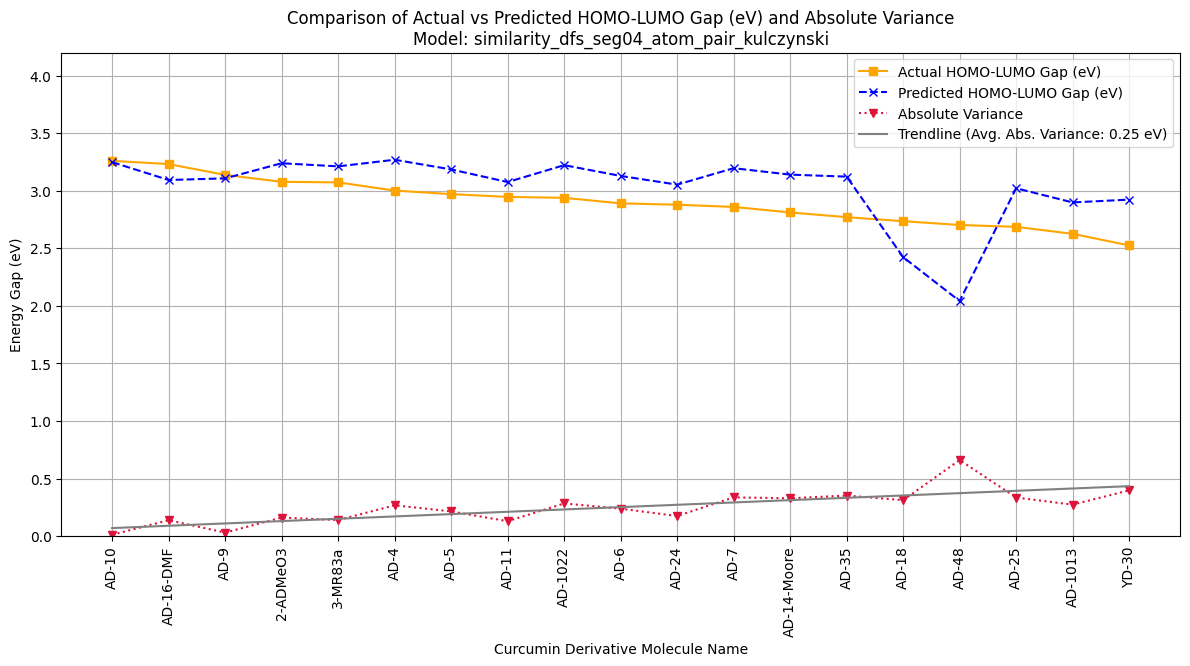

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006036 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1658
[LightGBM] [Info] Number of data points in the train set: 4667, number of used features: 829
[LightGBM] [Info] Start training from score 2.693293


c:\Users\Chamod Peiris\Documents\GitHub\Curcumin_BendGap_Cheminfo\.venv\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning:

'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.



___________________________________________________________________
Model similarity_dfs_seg05_atom_pair_kulczynski
MAE Value: 0.07424 & RMSE Value: 0.10861
Prediction --> model MAE: 0.46663 & RMSE: 0.25345
Prediction --> model R2 Score: -5.5990
___________________________________________________________________


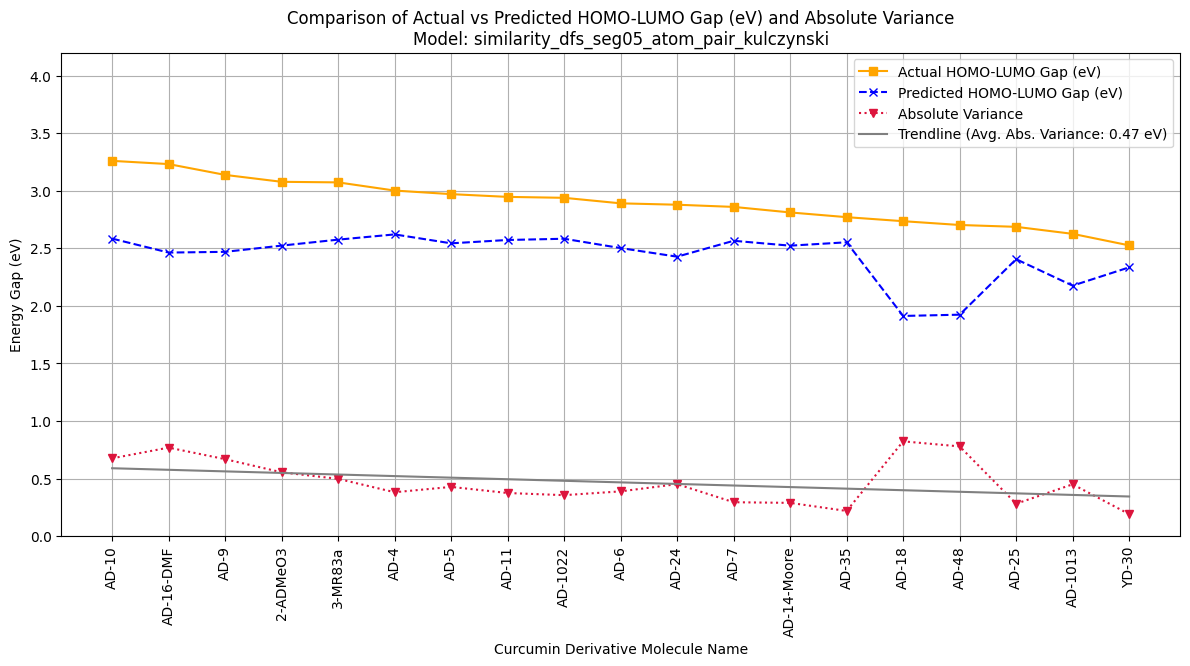

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006032 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1682
[LightGBM] [Info] Number of data points in the train set: 4612, number of used features: 841
[LightGBM] [Info] Start training from score 2.682568


c:\Users\Chamod Peiris\Documents\GitHub\Curcumin_BendGap_Cheminfo\.venv\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning:

'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.



___________________________________________________________________
Model similarity_dfs_seg06_atom_pair_cosine
MAE Value: 0.07895 & RMSE Value: 0.11286
Prediction --> model MAE: 0.20823 & RMSE: 0.07499
Prediction --> model R2 Score: -0.9526
___________________________________________________________________


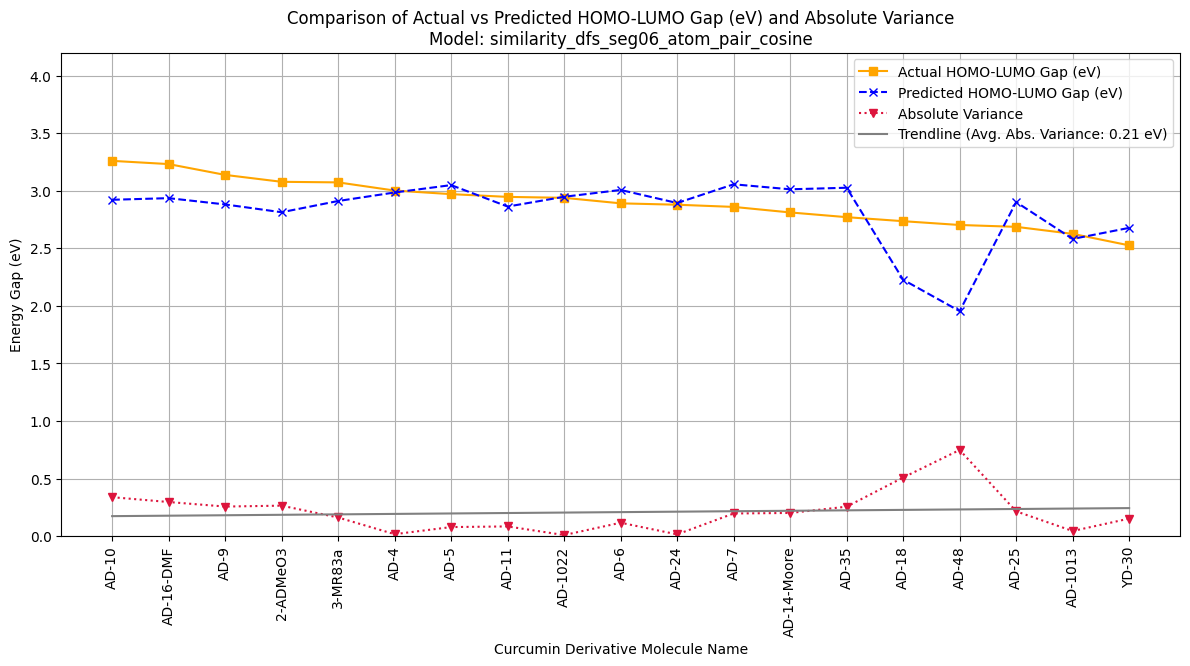

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
import lightgbm as lgb

# List of the best model dataframes
best_models_all_segments = ["similarity_dfs_seg01_atom_pair_cosine",
                            "similarity_dfs_seg02_atom_pair_cosine", 
                            "similarity_dfs_seg03_atom_pair_kulczynski", 
                            "similarity_dfs_seg04_atom_pair_kulczynski", 
                            "similarity_dfs_seg05_atom_pair_kulczynski",
                            "similarity_dfs_seg06_atom_pair_cosine"]

# Iterate through the list of best models
for model_name in best_models_all_segments:
    # Dynamically reference the corresponding dataframe
    model_df = globals()[model_name]
    
    x = model_df.iloc[:, 4:]
    y = model_df['GAP_calc']
    
    # Split the data into training and testing sets
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=123)
    
    # Initialize and train the LightGBM model
    tuned_params = {'n_estimators': 1000, 'learning_rate': 0.23685145356420312, 'num_leaves': 51}
    model = lgb.LGBMRegressor(**tuned_params)
    model.fit(x_train, y_train)
    
    # Make predictions and calculate R² score
    y_pred = model.predict(x_test)
    
    # Calculate MAE Value and RMSE for the model
    mae_model = mean_absolute_error(y_test, y_pred)
    rmse_model = mean_squared_error(y_test, y_pred, squared=False)
    
    # Calculate R² score for the model
    r2_model = model.score(x_test, y_test)

    # Ensure curcumin_df_mf's features are passed as a DataFrame for prediction
    curcumin_df_mf_pred = curcumin_df_mf.copy()
    curcumin_df_mf_pred['Homo-Lumo Gap (eV) Pred'] = model.predict(curcumin_df_mf.iloc[:, 5:].values)
    
    # Calculate MAE, RMSE, and R² for the predictions on curcumin_df_mf
    mae_predict = mean_absolute_error(curcumin_df_mf_pred['Homo-Lumo Gap (eV)'], curcumin_df_mf_pred['Homo-Lumo Gap (eV) Pred'])
    rmse_predict = mean_squared_error(curcumin_df_mf_pred['Homo-Lumo Gap (eV)'], curcumin_df_mf_pred['Homo-Lumo Gap (eV) Pred'])
    
    # For R², ensure both arrays are passed to the model's `score` function
    r2_predict = model.score(curcumin_df_mf.iloc[:, 5:], curcumin_df_mf['Homo-Lumo Gap (eV)'])
    
    print("___________________________________________________________________")
    print(f"Model {model_name}")
    print(f"MAE Value: {mae_model:.5f} & RMSE Value: {rmse_model:.5f}")
    print(f"Prediction --> model MAE: {mae_predict:.5f} & RMSE: {rmse_predict:.5f}")
    print(f"Prediction --> model R2 Score: {r2_predict:.4f}")   
    print("___________________________________________________________________")
    
    # Sort curcumin_df_mf_pred by 'Homo-Lumo Gap (eV)' in descending order and reset the index
    curcumin_df_mf_pred = curcumin_df_mf_pred.sort_values(by='Homo-Lumo Gap (eV)', ascending=False).reset_index(drop=True)
    
    # Calculate the absolute variance between 'Homo-Lumo Gap (eV)' and 'Homo-Lumo Gap (eV) Pred'
    curcumin_df_mf_pred['absolute_variance'] = (curcumin_df_mf_pred['Homo-Lumo Gap (eV)'] - curcumin_df_mf_pred['Homo-Lumo Gap (eV) Pred']).abs()
    
    # Save DF
    curcumin_df_mf_pred.to_csv(path_or_buf=(f"C:/Users/Chamod Peiris/Documents/Curcumin_Scripts/curcumin_pred_48_{model_name}.csv"))

    # Calculate linear trendline for absolute variance
    x_vals = curcumin_df_mf_pred.index
    y_vals = curcumin_df_mf_pred['absolute_variance']
    coefficients = np.polyfit(x_vals, y_vals, 1)  # Fit a linear polynomial
    trendline = np.polyval(coefficients, x_vals)
    
    # Calculate the average absolute variance
    average_variance = y_vals.mean()
    
    # Plotting the actual vs predicted energy gaps
    fig, ax1 = plt.subplots(figsize=(12, 6))
    
    # Plot the actual values
    ax1.plot(curcumin_df_mf_pred['Molecule'], curcumin_df_mf_pred['Homo-Lumo Gap (eV)'], marker='s', label='Actual HOMO-LUMO Gap (eV)', color='orange')
    
    # Plot the predicted values
    ax1.plot(curcumin_df_mf_pred['Molecule'], curcumin_df_mf_pred['Homo-Lumo Gap (eV) Pred'], marker='x', linestyle='--', label='Predicted HOMO-LUMO Gap (eV)', color='blue')
    
    # Plot the absolute variance as a dotted line
    ax1.plot(curcumin_df_mf_pred['Molecule'], curcumin_df_mf_pred['absolute_variance'], marker='v', linestyle=':', label='Absolute Variance', color='crimson')
    
    # Plot the trendline for absolute variance
    ax1.plot(curcumin_df_mf_pred['Molecule'], trendline, linestyle='-', color='grey', label=f'Trendline (Avg. Abs. Variance: {average_variance:.2f} eV)')
    
    # Set labels for the axes and the range
    ax1.set_xlabel('Curcumin Derivative Molecule Name')
    ax1.set_ylabel('Energy Gap (eV)')
    ax1.set_ylim([0, 4.2])  # Adjust the y-axis range as needed
    ax1.tick_params(axis='y')
    ax1.legend(loc='upper right')
    
    # Customize the plot
    plt.title(f'Comparison of Actual vs Predicted HOMO-LUMO Gap (eV) and Absolute Variance\nModel: {model_name}')
    plt.grid(True)
    plt.tight_layout()
    plt.xticks(rotation=90)
    
    # Show the plot
    plt.show()

In [25]:
intersect_df_seg01_atom_pair_cosine = similarity_dfs_seg01_atom_pair_cosine.iloc[:, :3]
intersect_df_seg02_atom_pair_cosine = similarity_dfs_seg02_atom_pair_cosine.iloc[:, :3]
intersect_df_seg03_atom_pair_kulczynski = similarity_dfs_seg03_atom_pair_kulczynski.iloc[:, :3]
intersect_df_seg04_atom_pair_kulczynski = similarity_dfs_seg04_atom_pair_kulczynski.iloc[:, :3]
intersect_df_seg05_atom_pair_kulczynski = similarity_dfs_seg05_atom_pair_kulczynski.iloc[:, :3]
intersect_df_seg06_atom_pair_cosine = similarity_dfs_seg06_atom_pair_cosine.iloc[:, :3]

intersect_df_seg01_atom_pair_tanimoto.columns

Index(['smiles', 'mol', 'GAP_calc'], dtype='object')

In [26]:
import pandas as pd

# List of dataframes
dataframes = [
    intersect_df_seg01_atom_pair_cosine,
    intersect_df_seg02_atom_pair_cosine,
    intersect_df_seg03_atom_pair_kulczynski,
    intersect_df_seg04_atom_pair_kulczynski,
    intersect_df_seg05_atom_pair_kulczynski,
    intersect_df_seg06_atom_pair_cosine
]

# Extract SMILES columns from all dataframes
smiles_sets = [set(df['smiles']) for df in dataframes]

# Find common SMILES across all dataframes
common_smiles = set.intersection(*smiles_sets)

# print number of comon smiles
print(f"Number of common SMILES: {len(common_smiles)}")

# Filter rows in each dataframe to only include those with common SMILES
filtered_dfs = [df[df['smiles'].isin(common_smiles)] for df in dataframes]
intersected_df = filtered_dfs[0]
intersected_df

Number of common SMILES: 4269


,smiles,mol,GAP_calc
1,Cn1c(C2=CC(=C(C#N)C#N)C=C(C(=O)C3=CC(=C(C#N)C#...,<rdkit.Chem.rdchem.Mol object at 0x000002A5C1D...,2.414079
3,CN1C(=O)C2=C(C3=CC(=C(C#N)C#N)C=C(C#N)O3)N(C)C...,<rdkit.Chem.rdchem.Mol object at 0x000002A5C1D...,1.919750
6,Cn1c(=O)c2cc(C3=CC(=C(C#N)C#N)C=CO3)c3c(=O)n(C...,<rdkit.Chem.rdchem.Mol object at 0x000002A5C1D...,2.013642
9,Cn1c(=O)c2cc(-c3cnc(C#N)nn3)c3c(=O)n(C)c(=O)c4...,<rdkit.Chem.rdchem.Mol object at 0x000002A6503...,2.890690
10,CN1C(=O)C2=C(C3=CC(=C(C#N)C#N)C=C(C(=O)O)O3)N(...,<rdkit.Chem.rdchem.Mol object at 0x000002A5C1D...,1.972455
...,...,...,...
6106,CN1C(=O)C(=Cc2onc(C3=C4C(=O)N(C)C([SiH]5C=C6OC...,<rdkit.Chem.rdchem.Mol object at 0x000002A5C1C...,2.125993
6108,CN1C(=O)C(=Cc2ncc(-c3ccnc(-c4c5ccsc5nc5sc(F)c(...,<rdkit.Chem.rdchem.Mol object at 0x000002A5C18...,2.705406
6109,CN1C(=O)C(=Cc2nccc(C=CC(=O)C=Cc3ccnc(C=C4SC(=S...,<rdkit.Chem.rdchem.Mol object at 0x000002A6503...,2.804085
6110,CN1C(=O)C(=Cc2onc(-c3ncnc([SiH]4C=C5OCCOC5=C4)...,<rdkit.Chem.rdchem.Mol object at 0x000002A5C1D...,2.685491


In [27]:
intersected_df['Morgan Fingerprints'] = intersected_df['smiles'].apply(generate_morgan_fingerprint_safe)
intersected_df = intersected_df[intersected_df['Morgan Fingerprints'].notnull()].reset_index(drop=True)

morgan_com_df = pd.DataFrame(intersected_df['Morgan Fingerprints'].tolist(), columns=[f'morgan_{i}' for i in range(2048)])
intersected_df = pd.concat([intersected_df, morgan_com_df], axis=1)
intersected_df = intersected_df.drop(columns=['Morgan Fingerprints'])

intersected_df

C:\Users\Chamod Peiris\AppData\Local\Temp\ipykernel_21864\4080543613.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,smiles,mol,GAP_calc,morgan_0,morgan_1,morgan_2,morgan_3,morgan_4,morgan_5,morgan_6,...,morgan_2038,morgan_2039,morgan_2040,morgan_2041,morgan_2042,morgan_2043,morgan_2044,morgan_2045,morgan_2046,morgan_2047
0,Cn1c(C2=CC(=C(C#N)C#N)C=C(C(=O)C3=CC(=C(C#N)C#...,<rdkit.Chem.rdchem.Mol object at 0x000002A5C1D...,2.414079,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,CN1C(=O)C2=C(C3=CC(=C(C#N)C#N)C=C(C#N)O3)N(C)C...,<rdkit.Chem.rdchem.Mol object at 0x000002A5C1D...,1.919750,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Cn1c(=O)c2cc(C3=CC(=C(C#N)C#N)C=CO3)c3c(=O)n(C...,<rdkit.Chem.rdchem.Mol object at 0x000002A5C1D...,2.013642,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Cn1c(=O)c2cc(-c3cnc(C#N)nn3)c3c(=O)n(C)c(=O)c4...,<rdkit.Chem.rdchem.Mol object at 0x000002A6503...,2.890690,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,CN1C(=O)C2=C(C3=CC(=C(C#N)C#N)C=C(C(=O)O)O3)N(...,<rdkit.Chem.rdchem.Mol object at 0x000002A5C1D...,1.972455,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4264,CN1C(=O)C(=Cc2onc(C3=C4C(=O)N(C)C([SiH]5C=C6OC...,<rdkit.Chem.rdchem.Mol object at 0x000002A5C1C...,2.125993,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4265,CN1C(=O)C(=Cc2ncc(-c3ccnc(-c4c5ccsc5nc5sc(F)c(...,<rdkit.Chem.rdchem.Mol object at 0x000002A5C18...,2.705406,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4266,CN1C(=O)C(=Cc2nccc(C=CC(=O)C=Cc3ccnc(C=C4SC(=S...,<rdkit.Chem.rdchem.Mol object at 0x000002A6503...,2.804085,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4267,CN1C(=O)C(=Cc2onc(-c3ncnc([SiH]4C=C5OCCOC5=C4)...,<rdkit.Chem.rdchem.Mol object at 0x000002A5C1D...,2.685491,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [28]:
curcumin_df_mf

,Molecule,Molecular Weight,LogP,Homo-Lumo Gap (eV),Smiles,morgan_0,morgan_1,morgan_2,morgan_3,morgan_4,...,morgan_2038,morgan_2039,morgan_2040,morgan_2041,morgan_2042,morgan_2043,morgan_2044,morgan_2045,morgan_2046,morgan_2047
0,2-ADMeO3,532.345,5.02930,3.077,COc3cc(OC)c(C/C=C/C2=CC(/C=C/Cc1c(OC)cc(OC)cc1...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,3-MR83a,472.293,5.01210,3.072,COc3ccc(C/C=C/C2=[O+][B-](F)(F)OC(/C=C/Cc1c(OC...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,AD-10,472.293,5.01210,3.259,COc3ccc(C/C=C/C2=CC(/C=C/Cc1ccc(OC)cc1OC)=[O+]...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,AD-1013,482.335,7.29270,2.625,COc5ccc(C/C=C/C4=[O+][B-](F)(F)OC(/C=C/Cc2c1cc...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,AD-1022,472.293,5.01210,2.938,COc3ccc(OC)c(C/C=C/C2=CC(/C=C/Cc1cc(OC)ccc1OC)...,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
5,AD-11,444.239,4.40610,2.946,COc3cc(C/C=C/C2=CC(/C=C/Cc1ccc(O)c(OC)c1)=[O+]...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,AD-14-Moore,438.327,5.10970,2.811,CN(C)c3ccc(C/C=C/C2=CC(/C=C/Cc1ccc(N(C)C)cc1)=...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,AD-16-DMF,377.199,4.84938,3.231,N#Cc3ccc(C/C=C/C2=[O+][B-](F)(F)OC(/C=C/Cc1ccc...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,AD-18,506.357,7.88370,2.735,COc6ccc(C/C=C/C5=CC(/C=C/Cc1cc2ccc3cccc4ccc(c1...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,AD-24,512.361,7.30130,2.878,COc4ccc(C/C=C/C3=CC(/C=C/Cc1ccc(OC)c2ccccc12)=...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004197 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1390
[LightGBM] [Info] Number of data points in the train set: 3201, number of used features: 695
[LightGBM] [Info] Start training from score 2.676687


c:\Users\Chamod Peiris\Documents\GitHub\Curcumin_BendGap_Cheminfo\.venv\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning:

'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.



MAE Value: 0.07492 & RMSE Value: 0.11261
Prediction --> model MAE: 0.22153 & RMSE: 0.09214


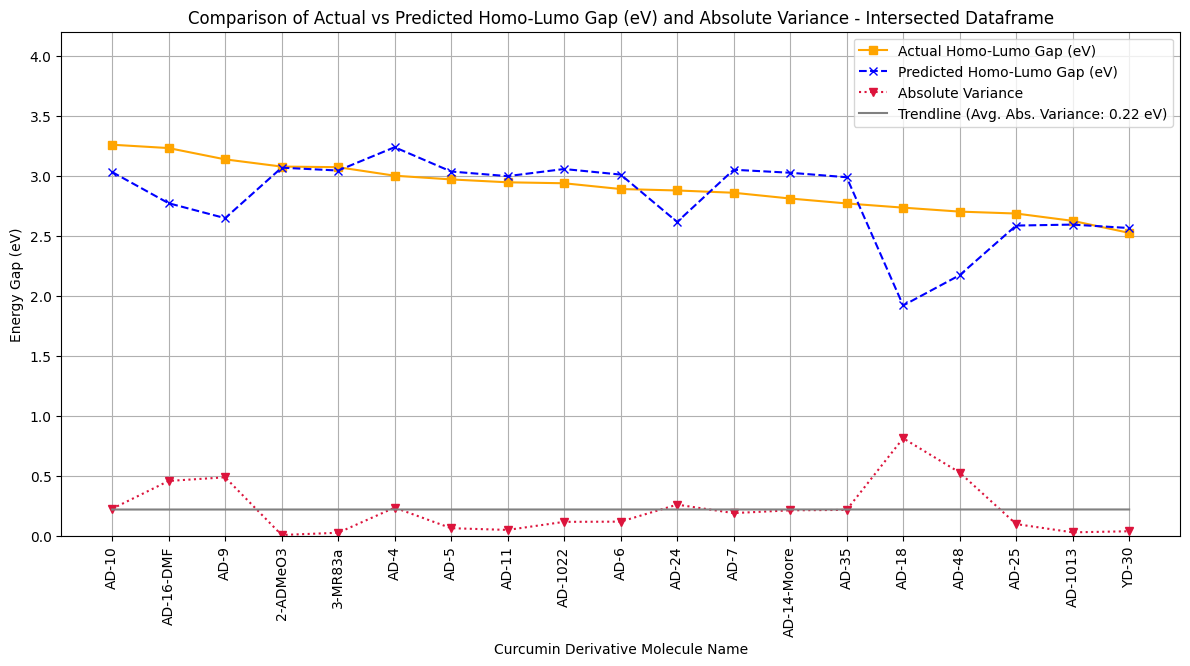

In [30]:
X = intersected_df.iloc[:, 3:]
y = intersected_df['GAP_calc']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=123)

# Initialize and train the LightGBM model
tuned_params = {'n_estimators': 1000, 'learning_rate': 0.23685145356420312, 'num_leaves': 51}
model = lgb.LGBMRegressor(**tuned_params)
model.fit(X_train, y_train)

# Make predictions and calculate R^2 score
y_pred = model.predict(X_test)

# Calculate MAE Value and RMSE for the model
mae_model = mean_absolute_error(y_test, y_pred)
rmse_model = mean_squared_error(y_test, y_pred, squared=False)

curcumin_df_mf_pred = curcumin_df_mf.copy()
curcumin_df_mf_pred['Homo-Lumo Gap (eV) Pred'] = model.predict(curcumin_df_mf.iloc[:, 5:])

mae_predict = mean_absolute_error(curcumin_df_mf_pred['Homo-Lumo Gap (eV)'], curcumin_df_mf_pred['Homo-Lumo Gap (eV) Pred'])
rmse_predict = mean_squared_error(curcumin_df_mf_pred['Homo-Lumo Gap (eV)'], curcumin_df_mf_pred['Homo-Lumo Gap (eV) Pred'])

print(f"MAE Value: {mae_model:.5f} & RMSE Value: {rmse_model:.5f}")
print(f"Prediction --> model MAE: {mae_predict:.5f} & RMSE: {rmse_predict:.5f}")

# Sort curcumin_df_mf_pred by 'Homo-Lumo Gap (eV)' in descending order and reset the index
curcumin_df_mf_pred = curcumin_df_mf_pred.sort_values(by='Homo-Lumo Gap (eV)', ascending=False).reset_index(drop=True)

# Calculate the absolute variance between 'Homo-Lumo Gap (eV)' and 'Homo-Lumo Gap (eV) Pred'
curcumin_df_mf_pred['absolute_variance'] = (curcumin_df_mf_pred['Homo-Lumo Gap (eV)'] - curcumin_df_mf_pred['Homo-Lumo Gap (eV) Pred']).abs()

# Save DF
curcumin_df_mf_pred.to_csv(path_or_buf=(f"C:/Users/Chamod Peiris/Documents/Curcumin_Scripts/curcumin_pred_Intersected.csv"))

# Calculate linear trendline for absolute variance
x_vals = curcumin_df_mf_pred.index
y_vals = curcumin_df_mf_pred['absolute_variance']
coefficients = np.polyfit(x_vals, y_vals, 1)  # Fit a linear polynomial
trendline = np.polyval(coefficients, x_vals)

# Calculate the average absolute variance
average_variance = y_vals.mean()

# Plotting the actual vs predicted energy gaps
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot the actual values
ax1.plot(curcumin_df_mf_pred['Molecule'], curcumin_df_mf_pred['Homo-Lumo Gap (eV)'], marker='s', label='Actual Homo-Lumo Gap (eV)', color='orange')

# Plot the predicted values
ax1.plot(curcumin_df_mf_pred['Molecule'], curcumin_df_mf_pred['Homo-Lumo Gap (eV) Pred'], marker='x', linestyle='--', label='Predicted Homo-Lumo Gap (eV)', color='blue')

# Plot the absolute variance as a dotted line
ax1.plot(curcumin_df_mf_pred['Molecule'], curcumin_df_mf_pred['absolute_variance'], marker='v', linestyle=':', label='Absolute Variance', color='crimson')

# Plot the trendline for absolute variance
ax1.plot(curcumin_df_mf_pred['Molecule'], trendline, linestyle='-', color='grey', label=f'Trendline (Avg. Abs. Variance: {average_variance:.2f} eV)')

# Set labels for the axes and the range
ax1.set_xlabel('Curcumin Derivative Molecule Name')
ax1.set_ylabel('Energy Gap (eV)')
ax1.set_ylim([0, 4.2])  # Adjust the y-axis range as needed
ax1.tick_params(axis='y')
ax1.legend(loc='upper right')

# Customize the plot
plt.title('Comparison of Actual vs Predicted Homo-Lumo Gap (eV) and Absolute Variance - Intersected Dataframe')
plt.grid(True)
plt.tight_layout()
plt.xticks(rotation=90)

# Show the plot
plt.show()